In data engineering and analytics, two major execution models exist:
 - **Eager execution**: computations run immediately when called.
 - **Lazy execution**: computations are only planned when written, and executed later in an optimized way.


Libraries like **Pandas** (eager), **Polars** (supports both eager and lazy), and **Spark** (lazy by default) give us a good ground for comparison.

 In this notebook, we’ll:
 1. Show how eager vs lazy works in **Polars**.
 2. Compare with **Spark DataFrame** execution.
 3. Discuss trade-offs, optimizations, and best practices.

In [0]:
pip install polars

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:

import polars as pl
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("LazyVsEagerDemo") \
    .getOrCreate()


In [0]:
# 3. Sample Dataset
# We'll create a simple dataset to demonstrate.

data = [
    {"id": 1, "category": "A", "value": 10},
    {"id": 2, "category": "B", "value": 20},
    {"id": 3, "category": "A", "value": 30},
    {"id": 4, "category": "B", "value": 40},
    {"id": 5, "category": "C", "value": 50},
]

pl_df = pl.DataFrame(data)
spark_df = spark.createDataFrame(data)

print("Polars DataFrame:")
print(pl_df)

print("\nSpark DataFrame:")
spark_df.show()

Polars DataFrame:
shape: (5, 3)
┌─────┬──────────┬───────┐
│ id  ┆ category ┆ value │
│ --- ┆ ---      ┆ ---   │
│ i64 ┆ str      ┆ i64   │
╞═════╪══════════╪═══════╡
│ 1   ┆ A        ┆ 10    │
│ 2   ┆ B        ┆ 20    │
│ 3   ┆ A        ┆ 30    │
│ 4   ┆ B        ┆ 40    │
│ 5   ┆ C        ┆ 50    │
└─────┴──────────┴───────┘

Spark DataFrame:
+--------+---+-----+
|category| id|value|
+--------+---+-----+
|       A|  1|   10|
|       B|  2|   20|
|       A|  3|   30|
|       B|  4|   40|
|       C|  5|   50|
+--------+---+-----+



In [0]:
# 4. Eager Execution in Polars
# With eager mode, computations happen immediately.

print("\nEager execution example (Polars):")
result_eager = pl_df.filter(pl.col("value") > 20).select(["id", "category"])
print(result_eager)



Eager execution example (Polars):
shape: (3, 2)
┌─────┬──────────┐
│ id  ┆ category │
│ --- ┆ ---      │
│ i64 ┆ str      │
╞═════╪══════════╡
│ 3   ┆ A        │
│ 4   ┆ B        │
│ 5   ┆ C        │
└─────┴──────────┘


In [0]:
## 5. Lazy Execution in Polars
# Lazy mode builds a query plan. Nothing is computed until `collect()` is called.

print("\nLazy execution example (Polars):")
lazy_query = pl_df.lazy().filter(pl.col("value") > 20).select(["id", "category"])

print("Query plan (optimized before running):")
print(lazy_query.explain())

print("\nNow execute:")
result_lazy = lazy_query.collect()
print(result_lazy)


Lazy execution example (Polars):
Query plan (optimized before running):
simple π 2/2 ["id", "category"]
  FILTER [(col("value")) > (20)]
  FROM
    DF ["id", "category", "value"]; PROJECT["id", "category", "value"] 3/3 COLUMNS

Now execute:
shape: (3, 2)
┌─────┬──────────┐
│ id  ┆ category │
│ --- ┆ ---      │
│ i64 ┆ str      │
╞═════╪══════════╡
│ 3   ┆ A        │
│ 4   ┆ B        │
│ 5   ┆ C        │
└─────┴──────────┘


In [0]:
## 6. Lazy Execution in Spark
# Spark DataFrames are lazy by default. Transformations build a DAG (Directed Acyclic Graph),
# but execution only happens on actions like `show()`, `count()`, `collect()`.

print("\nLazy execution example (Spark):")
spark_query = spark_df.filter(spark_df.value > 20).select("id", "category")

print("Transformation defined, but not executed yet.")
print("Execution plan:")
spark_query.explain()

print("\nNow trigger execution:")
spark_query.show()


Lazy execution example (Spark):
Transformation defined, but not executed yet.
Execution plan:
== Physical Plan ==
LocalTableScan [id#11151L, category#11150]


== Photon Explanation ==
Photon does not fully support the query because:
		Unsupported node: LocalTableScan [id#11151L, category#11150].

Reference node:
	LocalTableScan [id#11151L, category#11150]


Now trigger execution:
+---+--------+
| id|category|
+---+--------+
|  3|       A|
|  4|       B|
|  5|       C|
+---+--------+



6. Visual Diagrams (Eager vs Lazy)

Below are two visual aids added to the notebook:
 1. A simple flow diagram showing eager execution (step-by-step immediate execution).
 2. A DAG-style diagram showing lazy execution where transformations are recorded, optimized, then executed.


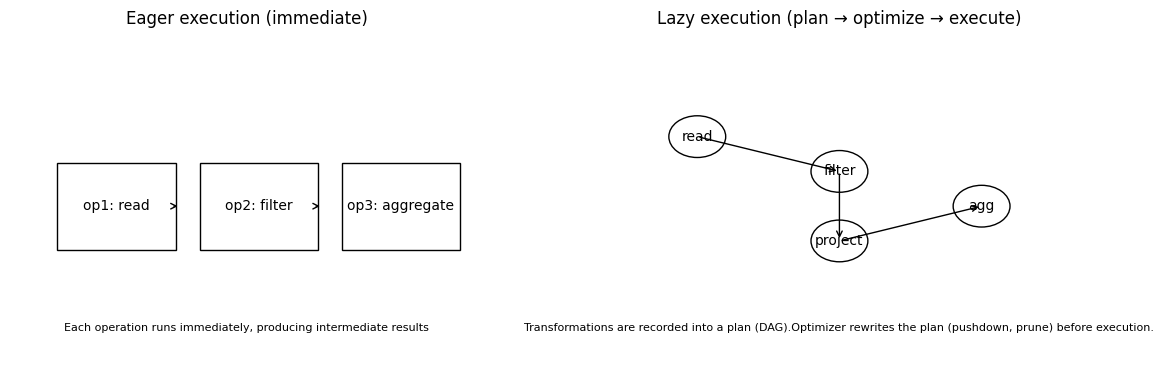

In [0]:
import matplotlib.pyplot as plt

# Draw two side-by-side diagrams: Eager flow (left) and Lazy DAG (right)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --- EAGER diagram (left)
ax = axes[0]
ax.set_title('Eager execution (immediate)')
ax.axis('off')

# Draw three boxes with arrows between them
boxes = [(0.1, 0.5, 0.25, 0.25), (0.4, 0.5, 0.25, 0.25), (0.7, 0.5, 0.25, 0.25)]
labels = ['op1: read', 'op2: filter', 'op3: aggregate']
for (x, y, w, h), lbl in zip(boxes, labels):
    rect = plt.Rectangle((x, y-h/2), w, h, fill=False)
    ax.add_patch(rect)
    ax.text(x + w/2, y, lbl, ha='center', va='center')

# arrows
ax.annotate('', xy=(0.36, 0.5), xytext=(0.34, 0.5), arrowprops=dict(arrowstyle='->'))
ax.annotate('', xy=(0.66, 0.5), xytext=(0.64, 0.5), arrowprops=dict(arrowstyle='->'))

ax.text(0.5, 0.15, 'Each operation runs immediately, producing intermediate results', ha='center', va='center', fontsize=8)

# --- LAZY diagram (right)
ax = axes[1]
ax.set_title('Lazy execution (plan → optimize → execute)')
ax.axis('off')

# Draw nodes of DAG
nodes = {'read': (0.2, 0.7), 'filter': (0.5, 0.6), 'project': (0.5, 0.4), 'agg': (0.8, 0.5)}
for name, (nx, ny) in nodes.items():
    circ = plt.Circle((nx, ny), 0.06, fill=False)
    ax.add_patch(circ)
    ax.text(nx, ny, name, ha='center', va='center')

# draw arrows between nodes
def arrow(a, b):
    ax.annotate('', xy=b, xytext=a, arrowprops=dict(arrowstyle='->'))

arrow(nodes['read'], nodes['filter'])
arrow(nodes['filter'], nodes['proj'] if 'proj' in nodes else nodes['project'])
arrow(nodes['project'], nodes['agg'])

ax.text(0.5, 0.15, 'Transformations are recorded into a plan (DAG).\
Optimizer rewrites the plan (pushdown, prune) before execution.', ha='center', va='center', fontsize=8)

plt.tight_layout()
plt.show()



 7. Performance Considerations
 - **Eager execution**: Simple, intuitive, good for small-to-medium data.
 - **Lazy execution**: Enables query optimization (predicate pushdown, projection pruning), better for large data.


 ---
 ## 8. Summary
 - **Polars**: Supports both eager and lazy execution.
 - **Spark**: Lazy execution only.
 - **Lazy execution advantages**: Optimizations, scalability.
 - **Eager execution advantages**: Simplicity, debugging ease.

 ### Best Practices
 - Use eager for exploration and debugging.
 - Use lazy (Polars or Spark) for production-scale pipelines.